# Training Notebook

In [84]:
import numpy as np
import tensorflow as tf
from backgammon import *
from RandomPlayer import *
from tqdm.notebook import tqdm

from tensorflow.keras.layers import Input, Dense, Dropout

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [42]:
rp1 = RandomPlayer("player 1")
rp2 = RandomPlayer("player 2")

go = play_game(rp1, rp2)

In [43]:
go.keys()

dict_keys(['winner', 'turns', 'boards', 'starting_player'])

Based on the the return of playing a game, I need to be able to tell which board was seen by which player, so I can decide to pair it with a win or a loss while training. (Note, I will need to flip boards associated with player 2 in training because I am going to train as if it is ALWAYS player 1. At least at first, It may be interesting to train a player 1 and a player 2 network later

In [51]:
# Get all of each player's boards
if (go['starting_player'].which == 'player 1'):
    p1_mod = 0
    p2_mod = 1
else:
    p1_mod = 1
    p2_mod = 0
    
boards = np.array(go['boards'])
p1_inds = np.where(np.arange(len(boards)) % 2 == p1_mod)[0]
p2_inds = np.where(np.arange(len(boards)) % 2 == p2_mod)[0]
p1_boards = boards[p1_inds]
p2_boards = boards[p2_inds]

In [53]:
# Get the outcome vectors for each of the players
if go['winner'].which == "player 1":
    p1_outcome = np.ones(p1_boards.shape[0])
    p2_outcome = np.zeros(p2_boards.shape[1])
else:
    p1_outcome = np.zeros(p1.boards.shape[0])
    p2_outcome = np.ones(p2.boards.shape[0])

The above gets me everything I should need to train. So now we need to setup the basics of a model. For now, I am going to setup a model for each of the different players, and I am going to make the architectures slightly different for each, this may help to decide if one is better than the other

In [171]:
class PlayerANN():
    def __init__(self, which):
        self.which = which
        self.setupNetwork()
        
    def setupNetwork(self):
        """
        Sets up the keras NN
        """
        in_layer = Input(shape=(28, ))
        d1 = Dense(40, activation='relu')(in_layer)
        d2 = Dense(10, activation='relu')(d1)
        out = Dense(1, activation='sigmoid')(d2)
        
        self.model = tf.keras.Model(inputs=in_layer, outputs=out)
        
    def action(self, board, vals):
        """
        Takes in the current board state and
        the value of the dice
        Returns the moves this player would like to make
        First, determiens all possible moves and the boards
        that would accompany them, then it runs all boards
        through the model and takes the move that yields
        the board with the highest probability of winning
        """
        # Get all the moves
        all_moves = get_all_moves(board, vals, self.which)
        
        if (len(all_moves) == 0):
            return []
        
        # Get all the boards for those moves
        board = np.copy(board)
        boards = np.zeros([len(all_moves), 28])
        i = 0
        for move in all_moves:
            boards[i] = update_by_moves(board, move)
        
        # Get the predicted probabilities for each board
        probs = self.model(boards)
        
        # Take the move with argmax board probs
        best_move = all_moves[np.argmax(probs)]
        
        return best_move
    
    def update_model(self, boards, outcomes, verbose=0):
        """
        Training step for the model, takes in the boards to be trained on
        and a vector of the outcomes associated with that board
        """
        # Compile the model
        self.model.compile(
            optimizer='adam',
            loss='mse'
        )
        
        # Train the model
        mf = self.model.fit(boards, outcomes, verbose=verbose)

In [172]:
p1 = PlayerANN("player 1")

In [173]:
b = init_state()
vals = roll()
print("Roll", vals)
pretty_print(b)

Roll [3 4]
Board:
[-5.  0.  0.  0.  3.  0.  5.  0.  0.  0.  0. -2.]
[ 5.  0.  0.  0. -3.  0. -5.  0.  0.  0.  0.  2.]
Bar: [0. 0.]
End: [0. 0.]


In [174]:
p1.action(b, vals)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



[[0, 3], [11, 15]]

In [175]:
p1.update_model(p1_boards, p1_outcome)

# Training one !!!!!
Just for fun, we are going to have our "smart" (or likely very dumb) model play against a random agent a whole butt load of times. After each game we are going to update the model. This will help us uncover any bugs, and give us some practice recording the necessary statistics and tracking outcomes.

In [ ]:
N_games = 10000
win_tracker = np.zeros(N_games)
turn_count_tracker = np.zeros(N_games)

# Initialize the players
p1 = PlayerANN("player 1")
# p2 = RandomPlayer("player 2")
p2 = PlayerANN("player 2")

c = 0
cum_boards = []
cum_outcomes = []
cum_boards2 = []
cum_outcomes2 =[]
first = True
for i in tqdm(range(N_games)):
    c += 1
    # Play the game
    obj = play_game(p1, p2)
    
    # Get the boards and outcomes
    if (obj['starting_player'].which == 'player 1'):
        p1_mod = 0
        p2_mod = 1
    else:
        p1_mod = 1
        p2_mod = 0

    boards = np.array(obj['boards'])
    p1_inds = np.where(np.arange(len(boards)) % 2 == p1_mod)[0]
    p2_inds = np.where(np.arange(len(boards)) % 2 == p2_mod)[0]
    p1_boards = boards[p1_inds]
    p2_boards = boards[p2_inds]
    
    if go['winner'].which == "player 1":
        p1_outcome = np.ones(p1_boards.shape[0])
        p2_outcome = np.zeros(p2_boards.shape[0])
    else:
        p1_outcome = np.zeros(p1.boards.shape[0])
        p2_outcome = np.ones(p2.boards.shape[0])
    
    # Track the outcome
    win_tracker[i] = 1 if obj['winner'].which == "player 1" else 2
    turn_count_tracker[i] = obj['turns']
    
    # Add boards and outcomes to intermediate trackers
    cum_boards.append(p1_boards)
    cum_outcomes.append(p1_outcome)
    cum_boards2.append(p2_boards)
    cum_outcomes2.append(p2_outcome)
    
    # Train every 100 games
    if (i % 50 == 0) and not first:
        # Stack the boards and outcomes
        stacked_boards = np.vstack(cum_boards)
        stacked_outcomes = np.concatenate(cum_outcomes)
        stacked_boards2 = np.vstack(cum_boards2)
        stacked_outcomes2 = np.concatenate(cum_outcomes2)
        
        # Update the model
        p1.update_model(stacked_boards, stacked_outcomes)
        p2.update_model(stacked_boards2, stacked_outcomes2)
    
    first = False
    # Train smart player
#     p1.update_model(p1_boards, p1_outcome)



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [162]:
# Find out how many times we won
print("Wins:", np.where(win_tracker == 1)[0].shape[0])
print("Wins Prop:", np.where(win_tracker == 1)[0].shape[0]/win_tracker.shape[0]en)

Wins: 770


In [163]:
import matplotlib.pyplot as plt

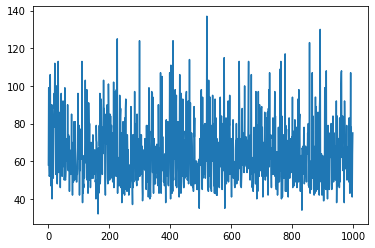

In [164]:
# Plot to see if as it learns the number of turns drops
plt.plot(turn_count_tracker)

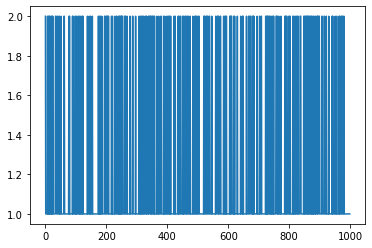

In [165]:
# Plot to see if there is a trend in palyer 1 starting to win more
plt.plot(win_tracker)

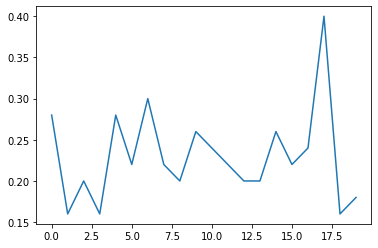

In [170]:
# Look at proportions of p1 winning per 50 games (training interval) over the 20 intervals
plt.plot(np.mean((win_tracker - 1).reshape(-1, 50), axis=1))